In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.transforms.functional import rotate, hflip
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob

In [2]:
# name = "emnistbyclass"
# name = "emnistbalanced"
name = "emnistbalanced_mathsymbols_custom"
# name = "mnist"
# name = "mathsymbols"
# name = "mnist_mathsymbols"
# name = "emnistbyclass_mathsymbols"

In [3]:
# EMNIST dataset
# split = "byclass"
# split = 'bymerge'
split = "balanced"
# split = 'letters'
# split = 'digits'
# split = "mnist"
emnist_train_data = datasets.EMNIST(
    root="data",
    split=split,
    train=True,
    download=True,
    transform=Compose([lambda img: rotate(img, -90), lambda img: hflip(img), ToTensor()]),
    target_transform=Lambda(lambda y: torch.tensor(y)),
)
emnist_test_data = datasets.EMNIST(
    root="data",
    split=split,
    train=False,
    download=True,
    transform=Compose([lambda img: rotate(img, -90), lambda img: hflip(img), ToTensor()]),
    target_transform=Lambda(lambda y: torch.tensor(y)),
)

In [4]:
# EMNIST balanced has 2400 train samples and 400 test samples per class
target_train_samples = 2400
target_test_samples = 400

# math_symbols = ["-", "(", ")", ",", "[", "]", "+", "=", "forward_slash", "gt", "lt", "times"]
math_symbols = ["gt", "lt", "(", ")", "[", "]", "=", "-", "+"]

custom_symbols = ["colon", "decimal"]

class_names = []

if "mnist" in name:
    class_names += [str(num) for num in range(10)]

if "emnist" in name:
    class_names += [chr(capital) for capital in range(ord("A"), ord("Z") + 1)]
    class_names += [chr(lower) for lower in range(ord("a"), ord("z") + 1)]

if "balanced" in name:
    class_names = [
        x
        for x in class_names
        if x not in {"c", "i", "j", "k", "l", "m", "o", "p", "s", "u", "v", "w", "x", "y", "z"}
    ]

if "math" in name:
    class_names += math_symbols

if "custom" in name:
    class_names += custom_symbols

print(len(class_names))
print(class_names)

58
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't', 'gt', 'lt', '(', ')', '[', ']', '=', '-', '+', 'colon', 'decimal']


In [5]:
# Math Symbols dataset
class MathSymbolsDataset(Dataset):
    def __init__(self, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]

        im = cv2.imread(img_path)

        # Grayscale
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        # Flip black and white
        im = cv2.bitwise_not(im)

        # Make lines thicker
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
        im = cv2.dilate(im, kernel, iterations=1)

        # Gaussian blur
        im = cv2.GaussianBlur(im, ksize=(3, 3), sigmaX=1, sigmaY=1)

        # Resize to 24x24
        im = cv2.resize(im, (24, 24), interpolation=cv2.INTER_CUBIC)

        # Add 2 pixel border for total size of 28x28
        border = 2
        im = cv2.copyMakeBorder(
            im, border, border, border, border, cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )

        # Normalize
        im = im / 255

        # Convert to tensor
        image = torch.from_numpy(im.astype("float32")).unsqueeze(0)

        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label).type(torch.LongTensor)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


math_symbols_root = "data/math_symbols"
train_datasets = []
test_datasets = []

for i, symbol in enumerate(math_symbols):
    # Get data as an array
    data = []
    root = f"{math_symbols_root}/{symbol}"
    for file in glob.glob(f"{root}/**/*.jpg", recursive=True):
        path = file.replace("\\", "/")
        label = i
        data.append([path, label])
    data = np.array(data)

    # Create dataframe
    df = pd.DataFrame(columns=["path", "label"])
    df["path"] = data[:, 0]
    df["label"] = data[:, 1].astype(int)
    offset = 0
    if "mnist" in name:
        offset += 10
    if "emnist" in name:
        offset += 52
    if "balanced" in name:
        offset -= 15
    df["label"] = df["label"] + offset

    # Calculate number of test samples
    test_samples = int(0.1 * len(df))
    remaining = len(df) - test_samples
    if remaining > target_train_samples:
        dif = remaining - target_train_samples
        test_samples = min(target_test_samples, test_samples + dif)

    # Split train/test
    train_df = df.iloc[test_samples:]
    test_df = df.iloc[:test_samples]

    # Over or under sample train set only
    if len(train_df) != target_train_samples:
        train_df = train_df.sample(
            n=target_train_samples, replace=(len(train_df) < target_train_samples), random_state=42
        )

    train_dataset = MathSymbolsDataset(train_df)
    test_dataset = MathSymbolsDataset(test_df)

    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)

math_symbols_train_data = ConcatDataset(train_datasets)
math_symbols_test_data = ConcatDataset(test_datasets)

print("Math symbols train size:", len(math_symbols_train_data))
print("Math symbols test size:", len(math_symbols_test_data))

Math symbols train size: 21600
Math symbols test size: 2227


In [6]:
# Custom Symbols dataset
class CustomSymbolsDataset(Dataset):
    def __init__(self, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]

        im = cv2.imread(img_path)

        # Grayscale
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        # Normalize
        im = im / 255

        # Convert to tensor
        image = torch.from_numpy(im.astype("float32")).unsqueeze(0)

        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label).type(torch.LongTensor)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


custom_symbols_root = "data/custom_symbols"
train_datasets = []
test_datasets = []

for i, symbol in enumerate(custom_symbols):
    # Get data as an array
    data = []
    root = f"{custom_symbols_root}/{symbol}"
    for file in glob.glob(f"{root}/**/*.jpg", recursive=True):
        path = file.replace("\\", "/")
        label = i
        data.append([path, label])
    data = np.array(data)

    # Create dataframe
    df = pd.DataFrame(columns=["path", "label"])
    df["path"] = data[:, 0]
    df["label"] = data[:, 1].astype(int)
    offset = 0
    if "mnist" in name:
        offset += 10
    if "emnist" in name:
        offset += 52
    if "balanced" in name:
        offset -= 15
    if "math" in name:
        offset += len(math_symbols)
    df["label"] = df["label"] + offset

    # Calculate number of test samples
    test_samples = int(0.1 * len(df))
    remaining = len(df) - test_samples
    if remaining > target_train_samples:
        dif = remaining - target_train_samples
        test_samples = min(target_test_samples, test_samples + dif)

    # Split train/test
    train_df = df.iloc[test_samples:]
    test_df = df.iloc[:test_samples]

    # Over or under sample train set only
    if len(train_df) != target_train_samples:
        train_df = train_df.sample(
            n=target_train_samples, replace=(len(train_df) < target_train_samples), random_state=42
        )

    train_dataset = CustomSymbolsDataset(train_df)
    test_dataset = CustomSymbolsDataset(test_df)

    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)

custom_symbols_train_data = ConcatDataset(train_datasets)
custom_symbols_test_data = ConcatDataset(test_datasets)

print("Custom symbols train size:", len(custom_symbols_train_data))
print("Custom symbols test size:", len(custom_symbols_test_data))

Custom symbols train size: 4800
Custom symbols test size: 22


In [7]:
train_data = []
test_data = []

if "mnist" in name:
    train_data.append(emnist_train_data)
    test_data.append(emnist_test_data)

if "math" in name:
    train_data.append(math_symbols_train_data)
    test_data.append(math_symbols_test_data)

if "custom" in name:
    train_data.append(custom_symbols_train_data)
    test_data.append(custom_symbols_test_data)

if len(train_data) == 1:
    train_data = train_data[0]
    test_data = test_data[0]
else:
    train_data = ConcatDataset(train_data)
    test_data = ConcatDataset(test_data)

Label: decimal


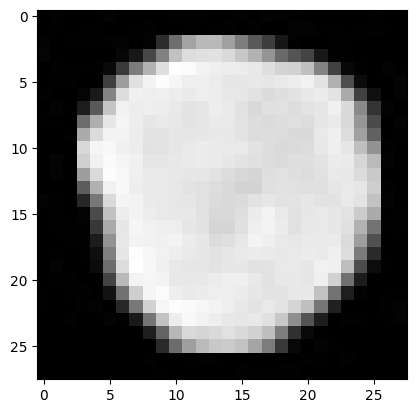

In [8]:
idx = np.random.randint(0, len(train_data))
sample_img, sample_label = train_data[idx]
plt.imshow(sample_img.reshape(28, 28), cmap="gray")
print("Label:", class_names[sample_label])

In [9]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

# for X, y in test_dataloader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
#     break

n_classes = len(class_names)
print("n_classes:", n_classes)

n_classes: 58


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout(p=0.4),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=64 * 20 * 20, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=128),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=128, out_features=n_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.4, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    preds = []
    labels = []
    with torch.no_grad():
        for X, y in dataloader:
            labels += y.tolist()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds += pred.argmax(1).tolist()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds, labels

In [14]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.387162  [   64/139200]
loss: 1.127124  [ 6464/139200]
loss: 0.831734  [12864/139200]
loss: 0.456437  [19264/139200]
loss: 0.573808  [25664/139200]
loss: 0.641516  [32064/139200]
loss: 0.414774  [38464/139200]
loss: 0.525711  [44864/139200]
loss: 0.469021  [51264/139200]
loss: 0.415999  [57664/139200]
loss: 0.356596  [64064/139200]
loss: 0.283599  [70464/139200]
loss: 0.479964  [76864/139200]
loss: 0.209255  [83264/139200]
loss: 0.601597  [89664/139200]
loss: 0.503927  [96064/139200]
loss: 0.604117  [102464/139200]
loss: 0.386256  [108864/139200]
loss: 0.303774  [115264/139200]
loss: 0.467578  [121664/139200]
loss: 0.273088  [128064/139200]
loss: 0.398330  [134464/139200]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.353852 

Epoch 2
-------------------------------
loss: 0.447513  [   64/139200]
loss: 0.276005  [ 6464/139200]
loss: 0.399171  [12864/139200]
loss: 0.404016  [19264/139200]
loss: 0.740987  [25664/139200]
loss: 0.282392  [32064/13

In [15]:
torch.save(model.state_dict(), f"model_{name}.pth")

In [16]:
model = CNN()
model.load_state_dict(torch.load(f"model_{name}.pth"))
model = model.to(device)

Predicted: "S", Actual: "S"


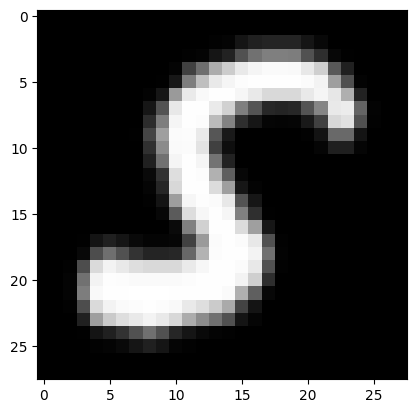

In [17]:
model.eval()
idx = np.random.randint(0, len(test_data))
x, y = test_data[idx]
with torch.no_grad():
    x = x.unsqueeze(0)
    pred = model(x.to(device))
    predicted, actual = class_names[pred[0].argmax(0)], class_names[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.imshow(x.reshape(28, 28), cmap="gray")

In [18]:
preds, labels = test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.281168 



In [19]:
correct = dict()
label_counts = dict()
for i in range(len(preds)):
    pred = preds[i]
    label = labels[i]
    label_counts[label] = label_counts.get(label, 0) + 1
    if pred == label:
        correct[label] = correct.get(label, 0) + 1
test_results = []
for idx, cor in correct.items():
    label_count = label_counts[idx]
    class_name = class_names[idx]
    perc = round(cor / label_count * 100, 1)
    test_results.append((class_name, cor, label_count, perc))
test_results.sort(key=lambda x: x[3])
for class_name, cor, label_count, perc in test_results:
    print(f"{class_name}: {cor}/{label_count} ({perc}%)")

L: 193/400 (48.2%)
O: 202/400 (50.5%)
q: 254/400 (63.5%)
f: 261/400 (65.2%)
I: 270/400 (67.5%)
g: 275/400 (68.8%)
F: 282/400 (70.5%)
1: 292/400 (73.0%)
9: 299/400 (74.8%)
0: 342/400 (85.5%)
2: 359/400 (89.8%)
Y: 363/400 (90.8%)
S: 366/400 (91.5%)
n: 368/400 (92.0%)
D: 368/400 (92.0%)
a: 369/400 (92.2%)
T: 370/400 (92.5%)
U: 373/400 (93.2%)
t: 373/400 (93.2%)
Z: 375/400 (93.8%)
4: 376/400 (94.0%)
h: 376/400 (94.0%)
V: 376/400 (94.0%)
5: 377/400 (94.2%)
Q: 377/400 (94.2%)
6: 377/400 (94.2%)
b: 378/400 (94.5%)
r: 380/400 (95.0%)
J: 382/400 (95.5%)
C: 385/400 (96.2%)
d: 386/400 (96.5%)
P: 386/400 (96.5%)
G: 386/400 (96.5%)
8: 389/400 (97.2%)
X: 390/400 (97.5%)
e: 390/400 (97.5%)
N: 391/400 (97.8%)
K: 392/400 (98.0%)
B: 392/400 (98.0%)
R: 393/400 (98.2%)
H: 393/400 (98.2%)
A: 394/400 (98.5%)
E: 394/400 (98.5%)
7: 396/400 (99.0%)
3: 396/400 (99.0%)
=: 397/400 (99.2%)
M: 397/400 (99.2%)
W: 397/400 (99.2%)
(: 397/400 (99.2%)
-: 398/400 (99.5%)
+: 399/400 (99.8%)
): 399/400 (99.8%)
[: 77/77 (10

In [20]:
counts = dict()
for img, label in train_data:
    class_name = class_names[label.item()]
    counts[class_name] = counts.get(class_name, 0) + 1
print(counts)

{'r': 2400, 'a': 2400, 'n': 2400, 'F': 2400, '4': 2400, 'h': 2400, 'Q': 2400, 'W': 2400, 'K': 2400, '1': 2400, 't': 2400, 'D': 2400, 'O': 2400, 'C': 2400, '5': 2400, 'H': 2400, '3': 2400, 'f': 2400, 'E': 2400, 'q': 2400, 'J': 2400, 'T': 2400, 'P': 2400, 'Z': 2400, 'S': 2400, 'N': 2400, 'M': 2400, 'Y': 2400, '9': 2400, 'U': 2400, 'd': 2400, 'e': 2400, 'b': 2400, 'V': 2400, 'G': 2400, '7': 2400, '2': 2400, '8': 2400, 'A': 2400, '6': 2400, 'R': 2400, 'X': 2400, 'B': 2400, 'I': 2400, 'g': 2400, '0': 2400, 'L': 2400, 'gt': 2400, 'lt': 2400, '(': 2400, ')': 2400, '[': 2400, ']': 2400, '=': 2400, '-': 2400, '+': 2400, 'colon': 2400, 'decimal': 2400}
